## Data Visualization
## A. Streming data visualization

<IPython.core.display.Javascript object>


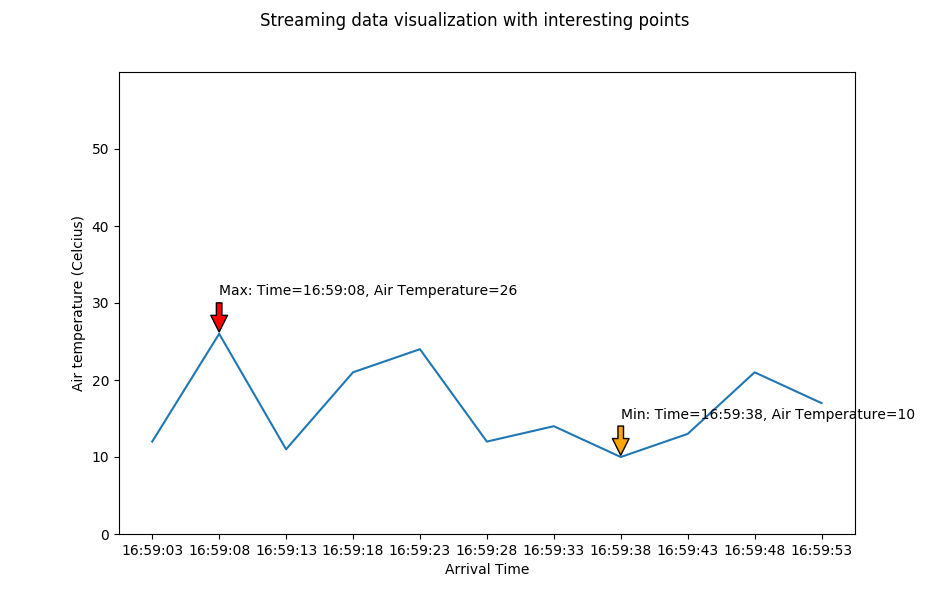

In [ ]:
# import statements
from time import sleep
from kafka import KafkaConsumer
import datetime as dt
import matplotlib.pyplot as plt
import json
import datetime

# this line is needed for the inline display of graphs in Jupyter Notebook
%matplotlib notebook

topic = 'fire'

def annotate_max(x, y, ax = None):
    ymax = max(y)
    xpos = y.index(ymax)
    xmax = x[xpos]
    text = 'Max: Time={}, Air Temperature={}'.format(xmax, ymax)
    if not ax:
        ax=plt.gca()
    ax.annotate(text, xy=(xmax, ymax), xytext=(xmax, ymax+5), arrowprops=dict(facecolor='red', shrink=0.05),)
    
def annotate_min(x, y, ax = None):
    ymin = min(y)
    xpos = y.index(ymin)
    xmin = x[xpos]
    text = 'Min: Time={}, Air Temperature={}'.format(xmin, ymin)
    if not ax:
        ax=plt.gca()
    ax.annotate(text, xy=(xmin, ymin), xytext=(xmin, ymin+5), arrowprops=dict(facecolor='orange', shrink=0.05),)

def connect_kafka_consumer():
    _consumer = None
    try:
         _consumer = KafkaConsumer(topic,
                                   consumer_timeout_ms=10000, # stop iteration if no message after 10 sec
                                   auto_offset_reset='earliest', # comment this if you don't want to consume earliest available message
                                   bootstrap_servers=['localhost:9092'],
                                   api_version=(0, 10))
    except Exception as ex:
        print('Exception while connecting Kafka')
        print(str(ex))
    finally:
        return _consumer

def init_plots():
    try:
        width = 9.5
        height = 6
        fig = plt.figure(figsize=(width,height)) # create new figure
        ax = fig.add_subplot(111) # adding the subplot axes to the given grid position
        fig.suptitle('Streaming data visualization with interesting points') # giving figure a title
        ax.set_xlabel('Arrival Time')
        ax.set_ylabel('Air temperature (Celcius)')
        ax.set_ylim(0,50) 
        ax.set_yticks([0,10,20,30,40,50])
        fig.show() # displaying the figure
        fig.canvas.draw() # drawing on the canvas
        return fig, ax
    except Exception as ex:
        print(str(ex))
    
def consume_messages(consumer, fig, ax):
    try:
        # container for x and y values
        x, y = [], []
        # print('Waiting for messages')
        for message in consumer:
            data = str(message.value.decode('utf-8'))
            data = json.loads(data)
            arrival_time = str(datetime.datetime.now().strftime("%X"))
            x.append(arrival_time) 
            y.append(int(data["air_temperature_celcius"]))
            # print(y)
            # we start plotting only when we have 10 data points
            if len(y) > 10:
                ax.clear()
                ax.plot(x, y)
                ax.set_xlabel('Arrival Time')
                ax.set_ylabel('Air temperature (Celcius)')
                ax.set_ylim(0,60) 
                ax.set_yticks([0,10,20,30,40,50])
                annotate_max(x,y)
                annotate_min(x,y)
                fig.canvas.draw()
                x.pop(0) # removing the item in the first position
                y.pop(0)
        plt.close('all')
    except Exception as ex:
        print(str(ex))
    
if __name__ == '__main__':
    
    consumer = connect_kafka_consumer()
    fig, ax = init_plots()
    consume_messages(consumer, fig, ax)

## B. Static data Visualization

In [2]:
from pymongo import MongoClient
from pprint import pprint

#connect to MongoDB and select the collection
client = MongoClient()
db = client.streaming_db
climate_collection = db.climate

### i. Records with the top 10 number of fires

#### Step 1: Query the top 10 number of fires.


In [3]:
#set interval for 5 mintues
interval = 5

pipeline = [{"$addFields": {"has_fire" : {"$size":"$hotspots"}}},
            {"$match": {"has_fire" : {"$gt":0}}},
            { "$group": {"_id": { "date_hour": { "$dateToString": { "format": "%Y-%m-%d %H", "date": "$created_time" }},
                                  "interval": { "$trunc": { "$divide": [{ "$minute": "$created_time" }, interval ]}}},
                         "count": { "$sum": 1 },
                        }
            },
            {"$sort" : {"count": -1}},
            {"$limit": 10},
            {"$project": {"_id":0, 
                          "count":1,
                          "time_stamp":"$_id.date_hour", 
                          "interval":"$_id.interval"
                         }
            }
           ]

results = climate_collection.aggregate(pipeline)

#for doc in results:
#    pprint(doc)

#### Step 2: Tranform the query result into python lists.

In [4]:
import matplotlib.pyplot as plt
import numpy as np

labels = []
count = []

for doc in results:
    labels.append("%s:%02d"%(doc["time_stamp"], int(doc["interval"]*interval)))
    count.append(doc["count"])

pprint(labels)
pprint(count)

['2019-05-24 18:40',
 '2019-05-24 18:15',
 '2019-05-24 18:10',
 '2019-05-24 17:10',
 '2019-05-24 18:35',
 '2019-05-24 17:45',
 '2019-05-24 17:05',
 '2019-05-24 17:40',
 '2019-05-24 18:45',
 '2019-05-24 18:20']
[9, 9, 7, 7, 5, 5, 4, 3, 3, 1]


#### Step 3: Plot a bar chart with time as the x-axis and number of fires as the y-axois.

<IPython.core.display.Javascript object>


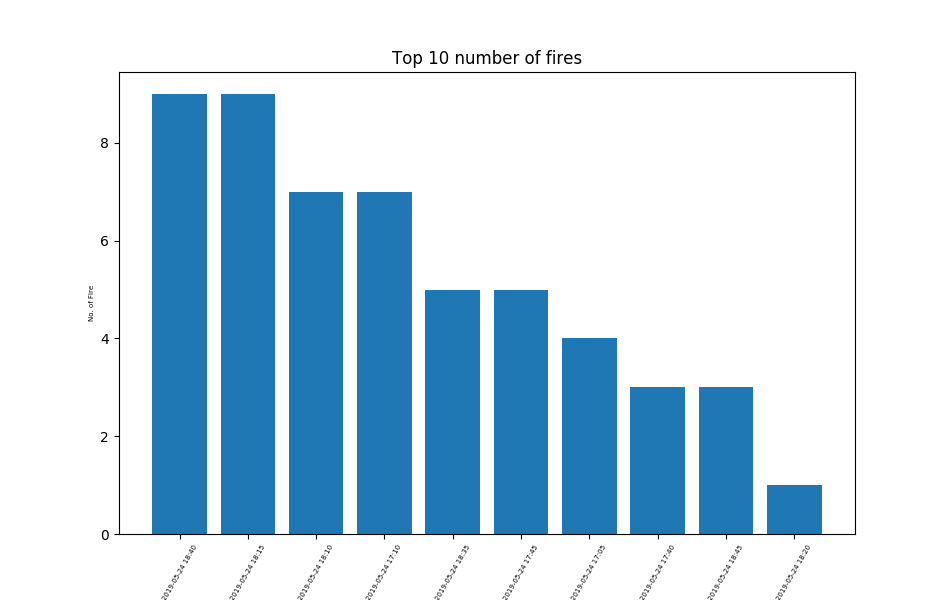

In [5]:
# this line is needed for the inline display of graphs in Jupyter Notebook
%matplotlib notebook

index = np.arange(len(labels))

width = 9.5
height = 6
fig = plt.figure(figsize=(width,height)) # create new figure
#ax = fig.add_subplot(111) # adding the subplot axes to the given grid position
#fig.suptitle('Streaming data visualization with interesting points') # giving figure a title
#ax.set_xlabel('Arrival Time')
#ax.set_ylabel('Air temperature (Celcius)')
#ax.set_ylim(0,50) 
#ax.set_yticks([0,10,20,30,40,50])

plt.bar(index, count)
plt.xlabel('Time interval', fontsize=5)
plt.ylabel('No. of Fire', fontsize=5)
plt.xticks(index, labels, fontsize=5, rotation=60)
plt.title('Top 10 number of fires')


fig.show() # displaying the figure
fig.canvas.draw() # drawing on the canvas

#plt.show()

### ii. Plot fire locations in the map with air temperature, surface temperature, relatve humidity and confidence 

#### Step 1: Query the data for visulaizing from MongoDB

In [6]:

pipeline = [{"$unwind":"$hotspots"},
            {"$project": {
                "_id":0, 
                "air_temperature_celcius":1,
                "surface_temperature_celcius":"$hotspots.surface_temperature_celcius", 
                "confidence":"$hotspots.confidence",
                "relative_humidity":1,
                "latitude": 1,
                "longitude": 1,
            }}
            
           ]

results = climate_collection.aggregate(pipeline)

#for doc in results:
#    pprint(doc)

#### Step 2: Visualizing using gmplot library

The example code for ploting the marker and setting tooltips on the map is retrived from
https://gis.stackexchange.com/questions/265972/tool-tips-in-gmplot

Require libraby: gmplot

Installation command: pip3 install gmplot 

In [7]:
import gmplot
import webbrowser

# gmplot contains a simple wrapper around 
# Google’s geocoding service enabling map initilization to the location of your choice.
gmap = gmplot.GoogleMapPlotter(-37.812015244225677, 144.951471202974, 8) # latitude and longitude of melbourne city and zoom level = 8

# Preparing the data for plotting
unoccupiedList = []

gmap.coloricon = "http://www.googlemapsmarkers.com/v1/%s/"

# Looping through all the data
for row in results:
    #Add marker to the map
    gmap.marker(row['latitude'], 
              row['longitude'],
              title="Surface temp:%.2f, Confidence:%.2f, Air temp:%.2f, Relative humidity:%.2f"%
              (row['surface_temperature_celcius'], row['confidence'], row['air_temperature_celcius'], row['relative_humidity']))

        

# Drawing the map
gmap.draw("Fire locations.html")
webbrowser.open_new("Fire locations.html")


True

Result map visualization:
![Example map](https://i.ibb.co/qBzryWK/map-visualization.png)
